# _Create city's urban area using AGEBs_

This notebook loads the specified city's municipalities, filters its AGEBs, buffers, dissolves and saves the result locally.

In [1]:
from pathlib import Path
current_path = Path().resolve()
for parent in current_path.parents:
    if parent.name == "accesibilidad-urbana":
        project_root = str(parent)+'/'
        break
print(project_root)

/home/jovyan/accesibilidad-urbana/


In [2]:
import os
import sys

import pandas as pd
import geopandas as gpd
import osmnx as ox
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

if project_root not in sys.path:
    sys.path.append(project_root)
import aup

## __Notebook config__

In [3]:
# Input city
city = 'Monterrey'
#Processing
projected_crs = 'EPSG:6372'
# Save directory
local_save_dir = project_root + 'data/processed/cities_footprint/'

## __Download city's AGEBs__

### Load city's municipalities

In [4]:
metro_schema = 'metropolis'
metro_table = 'metro_gdf_2020'
metro_query = f"SELECT * FROM {metro_schema}.{metro_table} WHERE \"city\" LIKE \'{city}\'"
metro_gdf = aup.gdf_from_query(metro_query, geometry_col='geometry')
metro_gdf = metro_gdf.set_crs("EPSG:4326")

# Show
print(metro_gdf.shape)
metro_gdf.head(2)

(16, 6)


,CVEGEO,CVE_ENT,CVE_MUN,NOMGEO,geometry,city
0,19006,19,006,Apodaca,"POLYGON ((-100.24794 25.86462, -100.24672 25.8...",Monterrey
1,19009,19,009,Cadereyta Jiménez,"POLYGON ((-99.93008 25.69451, -99.92950 25.694...",Monterrey


### Load city's AGEBs

In [5]:
cvegeo_mun_lst = list(metro_gdf.CVEGEO.unique())
# To avoid error that happens when there's only one MUN in State: 
# e.g.: <<< SELECT * FROM sociodemografico.censo_inegi_{year[2:]}_mza WHERE ("entidad" = '02') AND "mun" IN ('001',) >>>
# Duplicate mun inside tupple if there's only one MUN.
if len(cvegeo_mun_lst) >= 2:
    cvegeo_mun_tpl = str(tuple(cvegeo_mun_lst))
else:
    cvegeo_mun_lst.append(cvegeo_mun_lst[0])
    cvegeo_mun_tpl = str(tuple(cvegeo_mun_lst))

# Load AGEBs and blocks
ageb_query = f"SELECT * FROM sociodemografico.censo_inegi_20_ageb WHERE \"cvegeo_mun\" IN {cvegeo_mun_tpl}"
pop_ageb_gdf = aup.gdf_from_query(ageb_query, geometry_col='geometry')

# Show
print(pop_ageb_gdf.shape)
pop_ageb_gdf.head(2)

(2155, 235)


,nom_ent,nom_mun,nom_loc,pobtot,pobfem,pobmas,p_0a2,p_0a2_f,p_0a2_m,p_3ymas,...,cve_ent,cve_mun,cve_loc,cve_ageb,cve_mza,cvegeo_mun,cvegeo_loc,cvegeo_ageb,cvegeo_mza,geometry
0,Nuevo LeÃ³n,General Zuazua,Total AGEB urbana,26,9.0,17.0,NaN,0.0,NaN,25.0,...,19,025,0001,0324,000,19025,190250001,1902500010324,1902500010324000,"MULTIPOLYGON (((-100.12793 25.88570, -100.1280..."
1,Nuevo LeÃ³n,JuÃ¡rez,Total AGEB urbana,22,14.0,8.0,NaN,NaN,NaN,20.0,...,19,031,0001,2135,000,19031,190310001,1903100012135,1903100012135000,"MULTIPOLYGON (((-100.08080 25.62775, -100.0813..."


<Axes: >

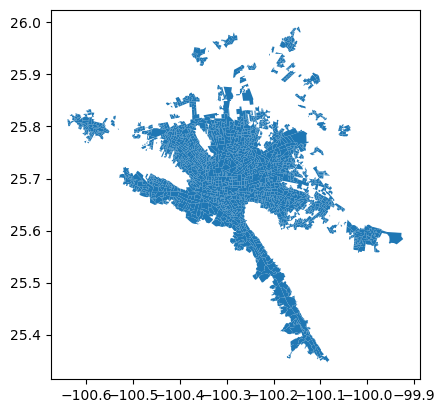

In [6]:
pop_ageb_gdf.plot()

### Create city's urban area

In [7]:
if pop_ageb_gdf.crs != projected_crs:
    pop_ageb_gdf = pop_ageb_gdf.to_crs(projected_crs)
city_urban_footprint = pop_ageb_gdf.buffer(10).reset_index().dissolve()

# Show
print(city_urban_footprint.shape)
city_urban_footprint.head(2)

(1, 2)


,0,index
0,"MULTIPOLYGON (((2651152.596 1514665.891, 26511...",0


<Axes: >

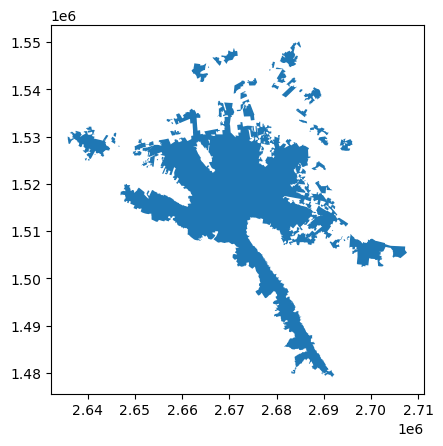

In [8]:
city_urban_footprint.plot()

### Save result

In [9]:
city_urban_footprint.to_file(local_save_dir+f'{city}_urban_footprint.gpkg')